# Homework 4

## Task A

I trained XGBoost model on wine dataset from Homework 1.
The model achieved 99% accuracy and for two sampled observations model predicted probabilities (of being a good wine): 0.0314907 and 0.9320484.
I calculated variable attributions for the first observation, using `dalex` and `shap` packages:

![image](./images/xgboost_shap_dx_1.png)
![image](./images/shap_1.png)

And for the second observation:

![image](./images/xgboost_shap_dx_2.png)
![image](./images/shap_2.png)

The results are similar for the two packages.

Next, I found two observations in the dataset, such that they have different variables of the highest importance. Again attributions are similar in two packages, but for 13th wine the most important feature is **alcohol** and for 19th wine, the most important one is **citric acid**. Results from `dalex` package:

![image](images/different_importance_dx.png)

and from the `shap` package:

![image](images/different_importances_shap_1.png)
![image](images/different_importances_shap_2.png)

Plots above also show example of variable X such that for one observation, X has a positive attribution, and for the other observation, X has a negative attribution - **alcohol** for 13th wine has positive attribution and negatie for the 19th wine.

To compare with XGBoost, I trained simple MLP network. The model achieved 81% accuracy. For a selected sample it predicted 0.68774192 probability for 'good wine' class, while XGBoost predicted 0.9320484 for this observation. SHAP attributions are different between the MLP and the XGBoost:
- **fixed acidity** has negative attribution in MLP model and positive in XGBoost
- **chlorides** are most important for XGBoost but have absolute value only 0.017 in MLP
- similarly **citric acid** and **pH** are important in XGBoost but not in MLP

![image](images/comparison_mlp.png)
![image](images/comparison_xgboost.png)

## Task B

$$ \phi_A = \frac{1}{3!} \sum_{\pi} \text{v}(S_A^{\pi} \cup \{ A \}) - \text{v}(S_A^{\pi})$$

There are 6 permutations:
- ABC, ACB - here $S_A^\pi = \emptyset$
- BCA, CBA - here $S_A^\pi = \{ B, C \}$
- BAC - here $S_A^\pi = \{ B \}$
- CAB - here $S_A^\pi = \{ C \}$

$$\phi_A = \frac{1}{3!} ( 2( v(\{A\}) - v(\emptyset) ) + 2( v(\{A, B, C\}) - v(\{B, C\}) ) + (v(\{A, B\}) - v(\{B\})) + (v(\{A, C\}) - v(\{C\}) )  ) = \frac{1}{6} (2 \cdot 20 + 2 \cdot 30 + 40 + 10) = \frac{150}{6} = 25$$

# Appendix

In [184]:
import plotly.io as pio
pio.renderers.default='notebook'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
import xgboost
import dalex as dx
import shap


In [160]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
df = pd.read_csv(url, sep=';')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [162]:
# 1
df['is good wine'] = [1 if x > 5 else 0 for x in df.quality]
X = df.drop(['quality', 'is good wine'], axis=1)
y = df['is good wine']

model = xgboost.XGBClassifier(
    n_estimators=200, 
    max_depth=4, 
    use_label_encoder=False, 
    eval_metric="logloss"
)
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [163]:
pf_xgboost_classifier_default = lambda m, d: m.predict_proba(d)[:, 1]

xgboost_explainer = dx.Explainer(model, X, y, predict_function=pf_xgboost_classifier_default, label="GBM")

Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4898 values
  -> model_class       : xgboost.sklearn.XGBClassifier (default)
  -> label             : GBM
  -> predict function  : <function <lambda> at 0x7f73e8285300> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.000294, mean = 0.665, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.983, mean = 2.25e-05, max = 0.776
  -> model_info        : package xgboost

A new explainer has been created!


In [164]:
xgboost_explainer.model_performance()

,recall,precision,f1,accuracy,auc
GBM,0.982505,0.960684,0.971472,0.961617,0.994175


In [165]:
shap_explainer = shap.explainers.Tree(model, data=X, model_output="probability")
shap_values = shap_explainer(X)

[00:07:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
 95%|=================== | 4669/4898 [00:11<00:00]       

In [166]:
# 2
np.random.seed(0)
sample = np.random.choice(len(X), 2)
xgboost_predictions = [xgboost_explainer.predict(X.iloc[[idx]]) for idx in sample]
xgboost_predictions

[array([0.0314907], dtype=float32), array([0.9320484], dtype=float32)]

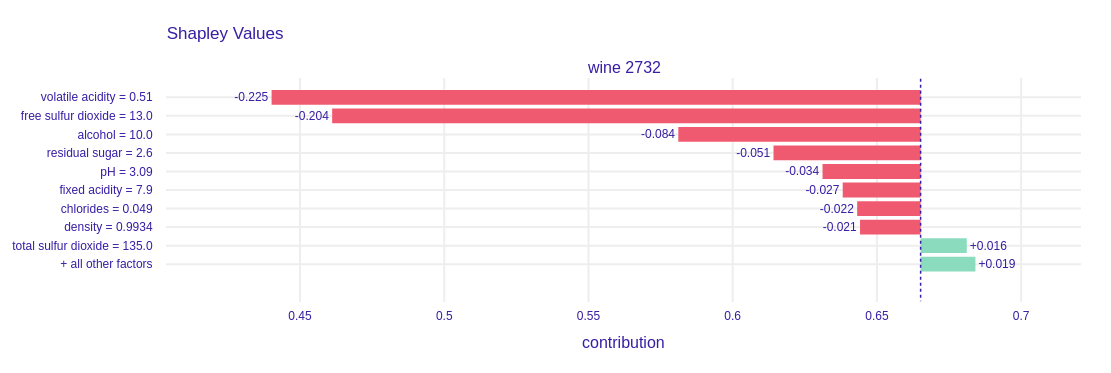

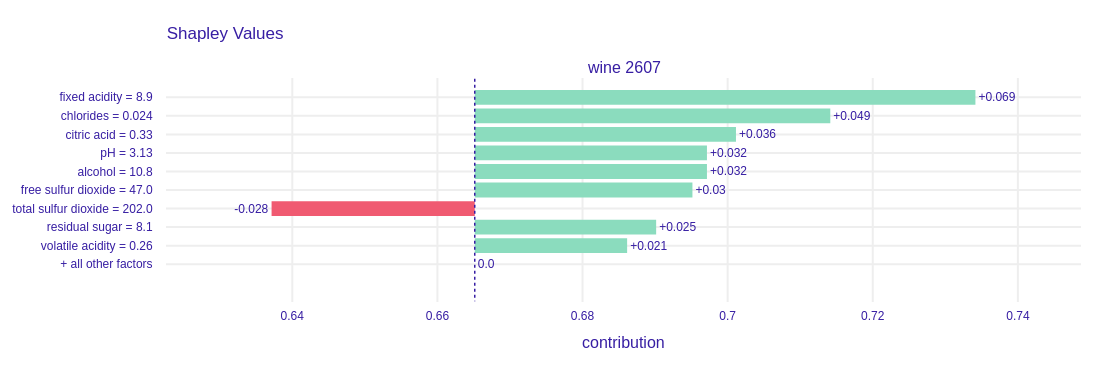

In [167]:
# 3
xgboost_shap_attributions = [xgboost_explainer.predict_parts(X.values[idx], type="shap", label=f'wine {idx}') for idx in sample]

for sa in xgboost_shap_attributions:
    sa.plot()

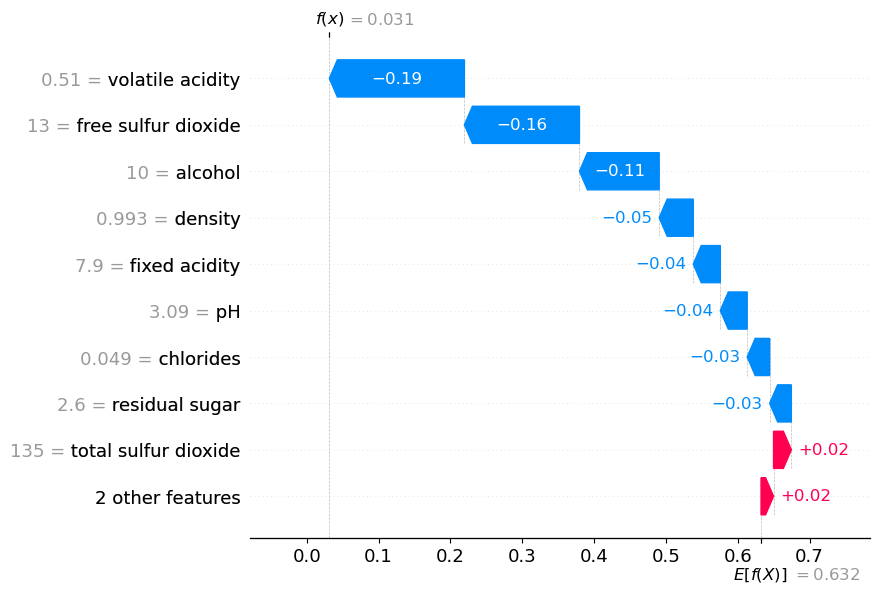

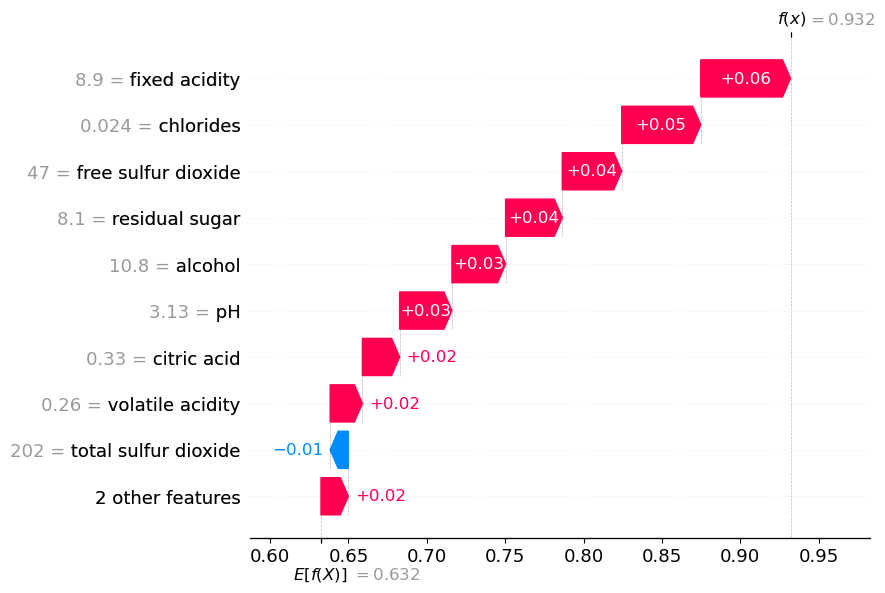

In [168]:
for idx in sample:
    shap.plots.waterfall(shap_values[idx])

[array([0.96171163]), array([0.57880315])]


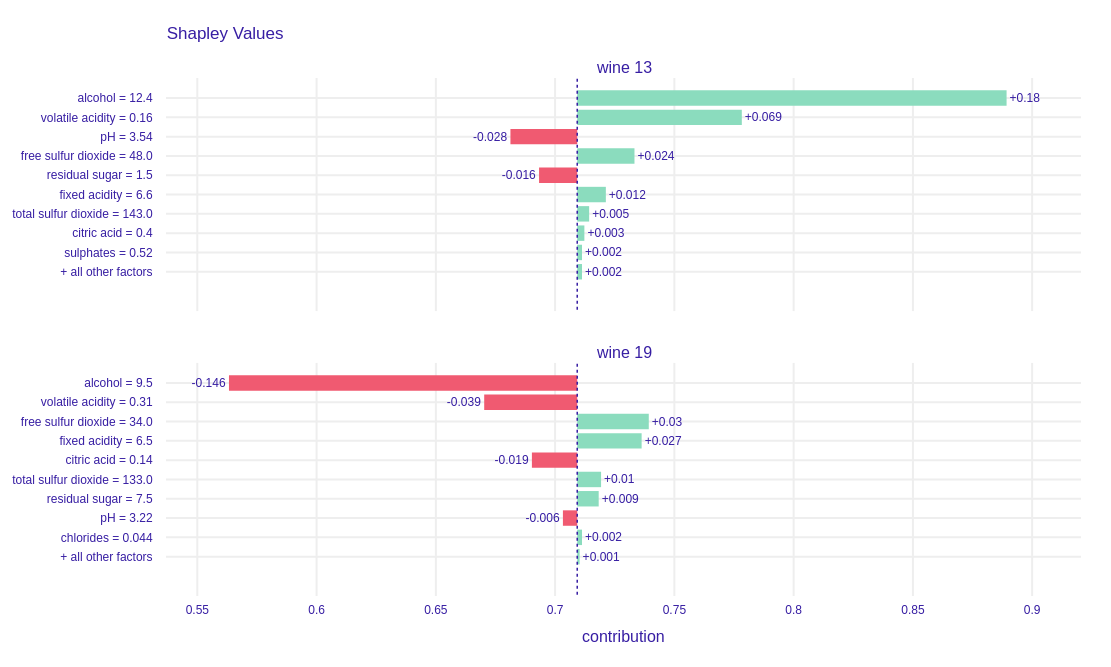

In [169]:
# 4 Find any two observations in the dataset, such that they have different variables of the highest importance,
test = [13, 19]
print([explainer.predict(X.iloc[[idx]]) for idx in test])
shap_attributions_importance = [explainer.predict_parts(X.values[idx], type="shap", label=f'wine {idx}') for idx in test]
shap_attributions_importance[0].plot(shap_attributions_importance[1::])

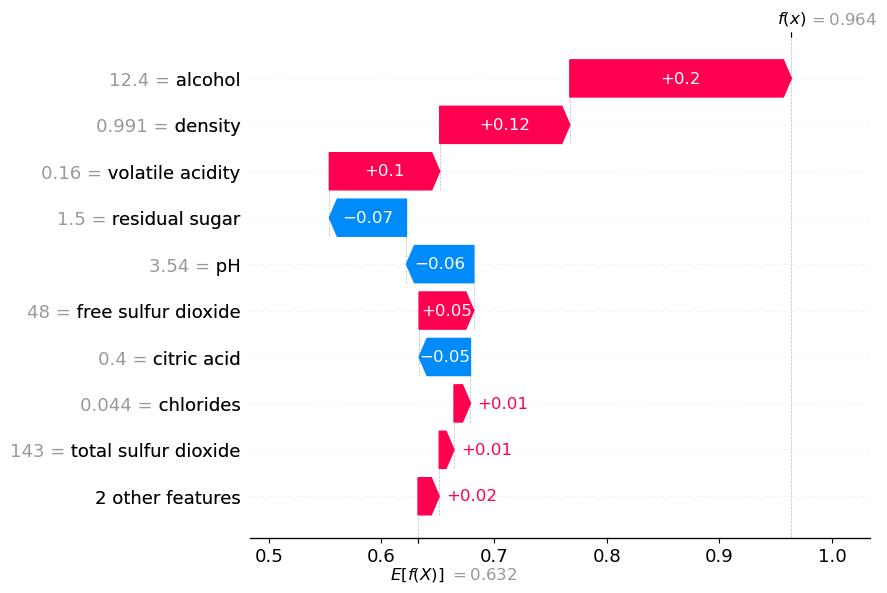

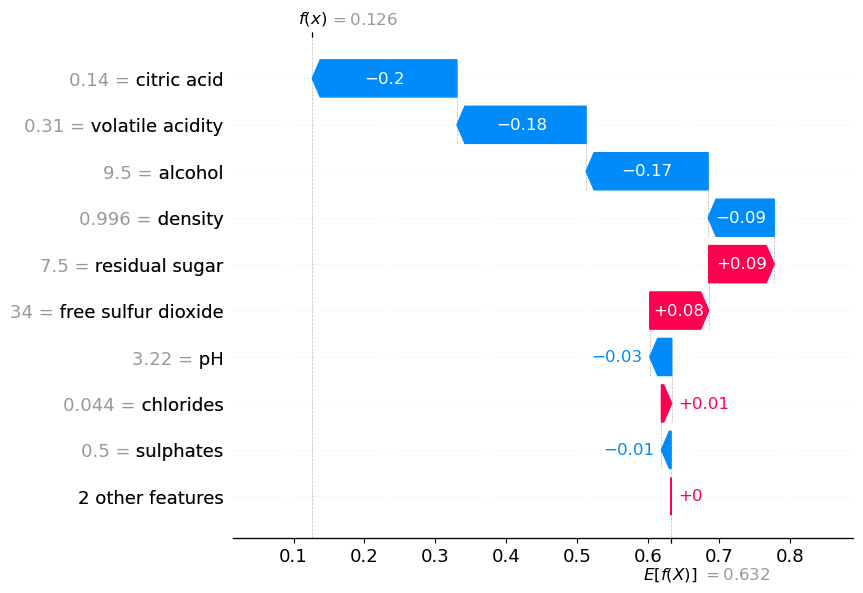

In [171]:
for idx in test:
    shap.plots.waterfall(shap_values[idx])

In [172]:
# 5 Select one variable X and find two observations in the dataset such that for one observation,
# X has a positive attribution, and for the other observation, X has a negative attribution
# Example above will work - alcohol has negative contribution for wine #19 and positive for wine #13

In [173]:
# 6
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='adam', hidden_layer_sizes=(6, 6), max_iter=2000, random_state=42, batch_size=100)
clf.fit(X, y)

MLPClassifier(batch_size=100, hidden_layer_sizes=(6, 6), max_iter=2000,
              random_state=42)

In [174]:
mlp_explainer = dx.Explainer(clf, X, y, predict_function=pf_xgboost_classifier_default, label="MLP")
mlp_explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 4898 rows 11 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 4898 values
  -> model_class       : sklearn.neural_network._multilayer_perceptron.MLPClassifier (default)
  -> label             : MLP
  -> predict function  : <function <lambda> at 0x7f73e8285300> will be used
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0246, mean = 0.709, max = 0.962
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.962, mean = -0.0441, max = 0.958
  -> model_info        : package sklearn

A new explainer has been created!


X does not have valid feature names, but MLPClassifier was fitted with feature names


,recall,precision,f1,accuracy,auc
MLP,0.9248,0.748014,0.827066,0.742752,0.80904


In [175]:
obs = sample[1]
mlp_explainer.predict(X.iloc[[obs]])

array([0.68774192])

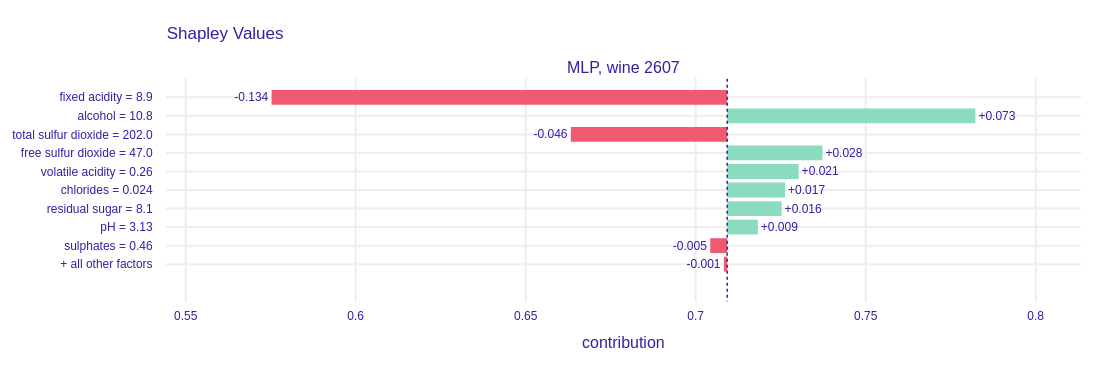

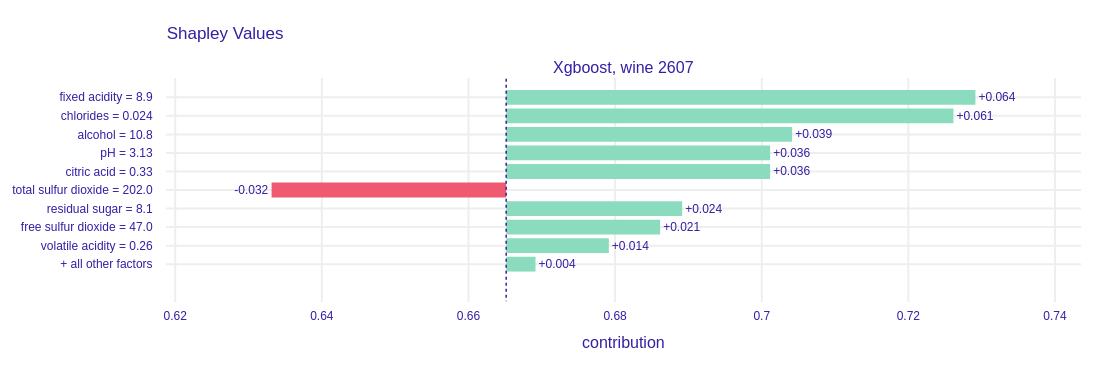

In [186]:
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)

mlp_shap_attribution = mlp_explainer.predict_parts(X.values[obs], type="shap", label=f'MLP, wine {obs}')
xgboost_shap_attribution = xgboost_explainer.predict_parts(X.values[obs], type="shap", label=f'Xgboost, wine {obs}')

mlp_shap_attribution.plot()
xgboost_shap_attribution.plot()